Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.30.0

torch: 2.6.0+cu126



# MobileNet-v3 (large) trained on Cifar-10

## Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, "..") # 将上一级目录添加到模块搜索路径中，以便导入../helper_evaluate.py等文件

# 从本地帮助文件导入所需函数
from helper_utils import set_all_seeds, set_deterministic  # 设置随机种子和确定性操作
from helper_evaluate import compute_confusion_matrix, compute_accuracy  # 用于计算混淆矩阵和准确率的函数
from helper_train import train_classifier_simple_v2  # 用于训练分类器的函数
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix  # 用于绘制训练损失、准确率、展示样本和绘制混淆矩阵的函数
from helper_data import get_dataloaders_cifar10, UnNormalize  # 用于加载CIFAR-10数据集的函数和反归一化操作

## Settings and Dataset

In [4]:
##########################
### 设置
########################## 

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 150
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [6]:
##########################
### CIFAR-10 数据集
##########################

### 注意：如果不进行尺寸调整（保持原始32x32尺寸），
# 网络训练速度大约会提高2-3倍，
# 但使用32x32的尺寸时，测试准确率较低，大约为77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),  # 将图片调整为70x70尺寸
    torchvision.transforms.RandomCrop((64, 64)),  # 随机裁剪成64x64尺寸
    torchvision.transforms.ToTensor(),  # 转换为Tensor格式
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化处理，均值和标准差为0.5
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),  # 将图片调整为70x70尺寸        
    torchvision.transforms.CenterCrop((64, 64)),  # 中心裁剪成64x64尺寸            
    torchvision.transforms.ToTensor(),  # 转换为Tensor格式                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化处理，均值和标准差为0.5
])

# 获取CIFAR-10数据集的dataloader
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,  # 批量大小
    validation_fraction=0.1,  # 验证集占总数据集的比例
    train_transforms=train_transforms,  # 训练数据的变换操作
    test_transforms=test_transforms,  # 测试数据的变换操作
    num_workers=2  # 数据加载时使用的子进程数
)

# 检查数据集
for images, labels in train_loader:  
    print('图片批次尺寸:', images.shape)  # 打印图片的尺寸
    print('图片标签尺寸:', labels.shape)  # 打印标签的尺寸
    print('10个样本的类标签:', labels[:10])  # 打印前10个样本的标签
    break

图片批次尺寸: torch.Size([128, 3, 64, 64])
图片标签尺寸: torch.Size([128])
10个样本的类标签: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


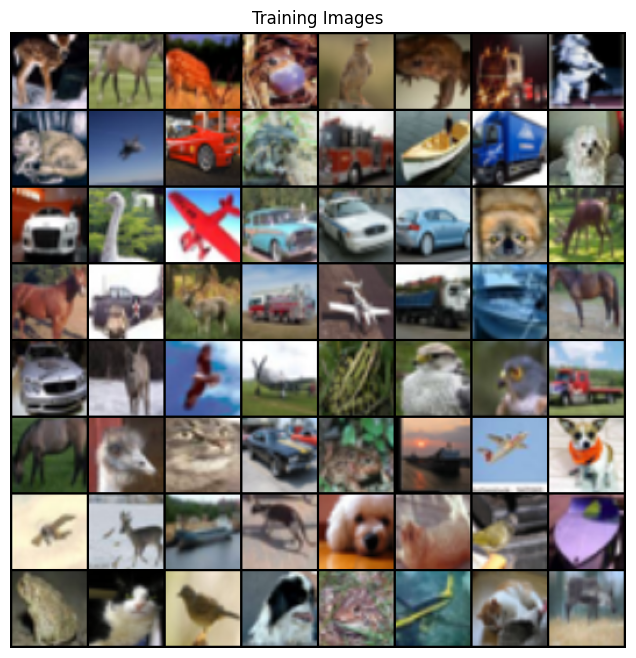

In [7]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

## Model

In [8]:
##########################
### 模型
##########################

# 选择加载 MobileNetV3 小型模型，并使用预训练权重
model = torchvision.models.mobilenet_v3_large(weights=None)

# 修改最后一层分类器，原模型的输出特征数为1280，CIFAR-10数据集有10个类别
model.classifier[-1] = torch.nn.Linear(in_features=1280,  # 原始模型的输入特征数
                                       out_features=10)  # CIFAR-10的类别数

# 将模型移动到指定的设备（例如GPU或CPU）
model = model.to(DEVICE)

Epoch: 001/150 | Batch 0000/0351 | Loss: 2.3101
Epoch: 001/150 | Batch 0100/0351 | Loss: 1.6964
Epoch: 001/150 | Batch 0200/0351 | Loss: 1.7912
Epoch: 001/150 | Batch 0300/0351 | Loss: 1.6553
Epoch: 001/150 | Train: 20.92% | Validation: 21.94% | Best Validation (Ep. 001): 21.94%
Time elapsed: 0.25 min
Epoch: 002/150 | Batch 0000/0351 | Loss: 1.6015
Epoch: 002/150 | Batch 0100/0351 | Loss: 1.3866
Epoch: 002/150 | Batch 0200/0351 | Loss: 1.3992
Epoch: 002/150 | Batch 0300/0351 | Loss: 1.2598
Epoch: 002/150 | Train: 39.80% | Validation: 40.42% | Best Validation (Ep. 002): 40.42%
Time elapsed: 0.49 min
Epoch: 003/150 | Batch 0000/0351 | Loss: 1.1973
Epoch: 003/150 | Batch 0100/0351 | Loss: 2.0092
Epoch: 003/150 | Batch 0200/0351 | Loss: 1.9154
Epoch: 003/150 | Batch 0300/0351 | Loss: 1.8008
Epoch: 003/150 | Train: 34.13% | Validation: 34.48% | Best Validation (Ep. 002): 40.42%
Time elapsed: 0.73 min
Epoch: 004/150 | Batch 0000/0351 | Loss: 1.6984
Epoch: 004/150 | Batch 0100/0351 | Loss: 1.

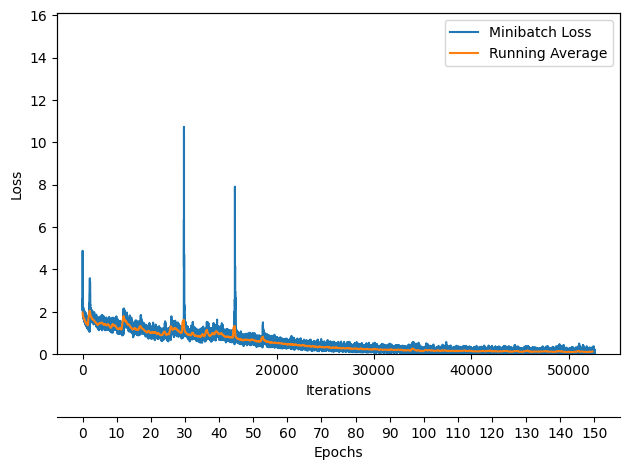

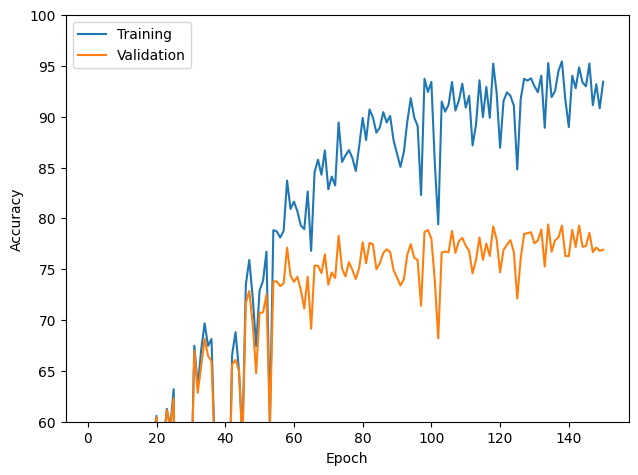

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

minibatch_loss_list, train_acc_list, valid_acc_list = train_classifier_simple_v2(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    best_model_save_path='mobilenet-v3-best-1.pt',
    device=DEVICE,
    scheduler_on='valid_acc',
    logging_interval=100)


plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [10]:
model.load_state_dict(torch.load('mobilenet-v3-best-1.pt'))
model.eval()
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 78.00%


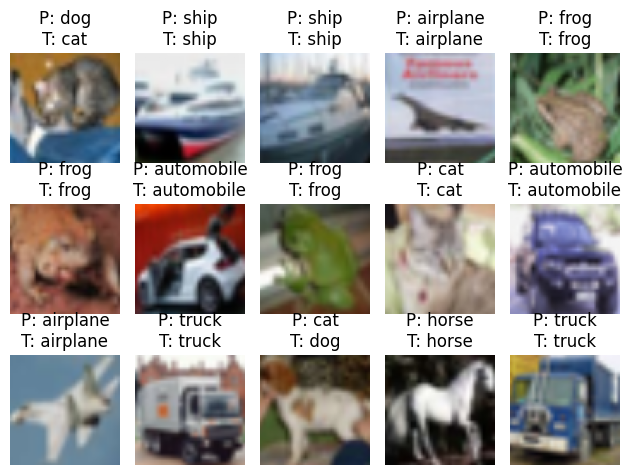

In [11]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

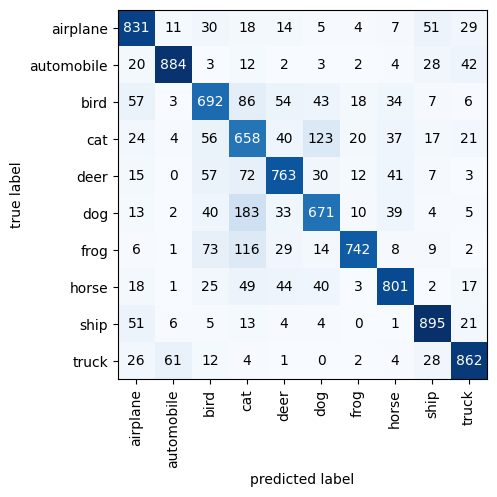

In [12]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()